# A modified CenterNet architecture for oriented bounding box detection

See the CenterNet official repo : https://github.com/xingyizhou/CenterNet

The main goal of this repo is to demonstrate how we can adapt the CenterNet ideas to multiple cars from a Bird Eye View as oriented bounding boxes. We train our network to predict a heatmap of the <b>box center</b> that is refined with an <b>offset map</b>. Then <b>bounding boxes dimensions</b> are regressed to get length and width of the vehicle. Orientation angle is also inferred with 2 heatmaps, <b>one for cosine and for sine</b>. In terms of architecture, another difference with CenterNet is that we are not using any upsampling layers, since detection of small objects doesnt require a global information of the original image.

# Summary
- import and display your dataset
- define utility functions to draw heatmaps and how we can recover oriented bounding boxes from main heatmap, offset heatmaps, width and height heatmaps, and sine/cosine heatmaps
- make a Pytorch dataset for training and validation
- define the model with a Resnet-18 backbone
- define our loss
- train the network
- display a few predictions on the validation dataset

# Imports

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim

assert torch.cuda.is_available()

# Not always necessary depending on your hardware/GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [2]:
# Here we dont assume that our images are 512x512 we prefer to use HD images (more common)
input_width = 640
input_height = 640

# Model scale is 16, meaning that in the model prediction, we have heatmaps of dimensions 80 x 45
MODEL_SCALE = 16 #4

# Batch size for training --> if your hardware supports it, try to increase this value
batch_size = 4

Image IMG_2406_jpeg_jpg.rf.66728aeced659fcdf65aa0d09e90c38e.jpg


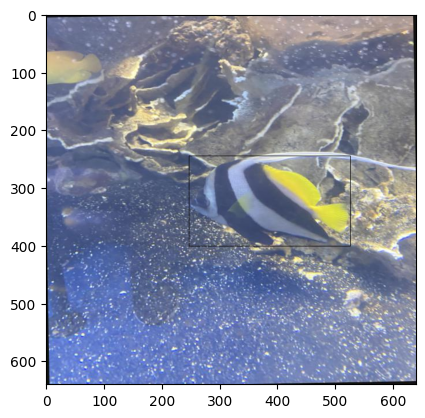

In [3]:
dataset_folder = '/home/rivian/Desktop/Datasets/Aquarium Combined.v3-video-inference.tensorflow/'
labels_file = dataset_folder +  "train_annotations.csv"
    
# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load labels
train_df = pd.read_csv(labels_file)
classes = train_df["class"].unique()

train_df['x'] = train_df['xmin'].astype(float)
train_df['y'] = train_df['ymin'].astype(float)
train_df['w'] = train_df['xmax'].astype(float) - train_df['xmin'].astype(float)
train_df['h'] = train_df['ymax'].astype(float) - train_df['ymin'].astype(float)
target = train_df[train_df['filename']==IMAGE]
centers = np.array([target["x"], target["y"]]).T
bboxs = target[["x", "y", "w", "h"]].to_numpy().astype(int)
train_df.head()
for box in bboxs:
    cv2.rectangle(img,(box[0],box[1]),(box[0]+box[2],box[1]+box[3]),2)
plt.imshow(img)

In [4]:
classes

array(['fish', 'starfish', 'jellyfish', 'shark', 'stingray', 'penguin',
       'puffin'], dtype=object)

# Load dataset

dataset_folder = '/home/ai/Desktop/Datasets/box_4corner_img/'
labels_file = dataset_folder +  "labels.csv"

# Pick up a random image
IMAGE = random.choice(os.listdir(dataset_folder+"train"))

print(f"Image {IMAGE}")

img = cv2.imread(os.path.join(dataset_folder+"train", IMAGE))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Load labels
train_df = pd.read_csv(labels_file)
train_df['x'] = train_df['x'].astype(float)
train_df['y'] = train_df['y'].astype(float)
train_df['w'] = train_df['w'].astype(float)
train_df['h'] = train_df['l'].astype(float)
train_df['angle'] = train_df['angle'].astype(float)

print(f"Image shape = {img.shape}")

target = train_df[train_df['name']==IMAGE[:-4]]
print(target)

# convert targets to its center.
centers = np.array([target["x"], target["y"]]).T

rotations = []
for angle in target["angle"]:
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotations.append(np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]]))

bboxs = target[["x", "y", "w", "l"]].to_numpy()

for center, rot, box in zip(centers, rotations, bboxs):
    bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
    bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
    
    br = (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1]))
    tr = (int(center[0]+top_right[0]), int(center[1]+top_right[1]))
    tl = (int(center[0]+top_left[0]), int(center[1]+top_left[1]))
    bl = (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1]))

    thickness = 3
    cv2.line(img, br, tr, (0, 220, 0), thickness)
    cv2.line(img, br, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, bl, (220, 220, 0), thickness)
    cv2.line(img, tl, tr, (220, 220, 0), thickness)

#plt.figure(figsize=(14,14))
plt.imshow(img)

# Utility functions

Let's plot center points into the image.

In [5]:
# Make heatmaps using the utility functions from the centernet repo
def draw_msra_gaussian(heatmap, center, sigma=2):
    tmp_size = sigma * 6
    mu_x = int(center[0])
    mu_y = int(center[1])
    w, h = heatmap.shape[0], heatmap.shape[1]
    ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
    br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
    if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
        return heatmap
    size = br[0] - ul[0]
    x = np.arange(0, size, 1, np.float32)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
    img_x = max(0, ul[0]), min(br[0], h)
    img_y = max(0, ul[1]), min(br[1], w)
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
      heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
      g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
    
    assert heatmap[mu_y, mu_x] == 1 # Center value must be 1
    return heatmap

# Offsets along x and y are between 0 and 1 and correct quantization errors from center heatmap
def draw_offset(offset, x, y):
    offset[0, int(y), int(x)] = x - int(x)
    offset[1, int(y), int(x)] = y - int(y)
    return offset

In [6]:
for i, c in train_df.iterrows():
    print(i,c)
    break

0 filename    IMG_8537_jpg.rf.60c0cd61ba3d45c68f1b69153d398c...
width                                                     640
height                                                    640
class                                                    fish
xmin                                                      135
ymin                                                        0
xmax                                                      187
ymax                                                      161
x                                                       135.0
y                                                         0.0
w                                                        52.0
h                                                       161.0
Name: 0, dtype: object


In [7]:
classes

array(['fish', 'starfish', 'jellyfish', 'shark', 'stingray', 'penguin',
       'puffin'], dtype=object)

In [8]:
# Heatmap function
# MODEL_SCALE = 16 ==> 1280 to 80, 720 ==> 45
def make_hm_offset_regr_angle(target):
    hm = np.zeros([len(classes),input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    hm_all = np.zeros([input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    offset = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    regr = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
    #cos_sin_hm = np.zeros([2, input_height//MODEL_SCALE, input_width//MODEL_SCALE])
     
    if len(target) == 0:
        return hm, offset, regr , hm_all
    
    # choice of sigma is important here, if you are working with very tiny objects, you should decrease the sigma value
    for i, c in target.iterrows():
        c["x"] = (c["x"] + ( c["x"] + c["w"])) / 2
        c["y"] = (c["y"] + ( c["y"] + c["h"])) / 2
        cls = list(classes).index(c["class"])
        hm[cls] = draw_msra_gaussian(hm[cls], [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=1)
        hm_all = draw_msra_gaussian(hm_all, [int(c["x"]/MODEL_SCALE), int(c["y"]/MODEL_SCALE)], 
                                sigma=1)
        assert 0 <= c["x"] < 640
        assert 0 <= c["y"] < 640
        offset = draw_offset(offset, c["x"]/MODEL_SCALE, c["y"]/MODEL_SCALE)
        
        for i in range(-1, 2):
            for j in range(-1, 2):
                try:
                    regr[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["w"]/MODEL_SCALE
                    regr[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = c["h"]/MODEL_SCALE
                    #cos_sin_hm[0, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.cos(c["angle"])
                    #cos_sin_hm[1, int(c["y"]/MODEL_SCALE)+i, int(c["x"]/MODEL_SCALE)+j] = np.sin(c["angle"])
                except:
                    pass
        #angles= target["angle"]
        
                
    #regr[0] = regr[0].T; regr[1] = regr[1].T;
    #angle = angle.T
    return hm, offset, regr, hm_all #, cos_sin_hm


In [9]:
def select(hm, threshold):
    """
    Keep only local maxima (kind of NMS).
    We make sure to have no adjacent detection in the heatmap.
    """

    pred = hm > threshold
    pred_centers = np.argwhere(pred)

    for i, ci in enumerate(pred_centers):
        for j in range(i + 1, len(pred_centers)):
            cj = pred_centers[j]
            if np.linalg.norm(ci - cj) <= 2:
                score_i = hm[ci[0], ci[1]]
                score_j = hm[cj[0], cj[1]]
                if score_i > score_j:
                    hm[cj[0], cj[1]] = 0
                else:
                    hm[ci[0], ci[1]] = 0

    return hm

In [10]:
def pred2box(hm, offset, regr, thresh=0.5):
    # make binding box from heatmaps
    # thresh: threshold for logits.
        
    # get center
    pred = hm > thresh
    pred_center = np.where(hm>thresh)
    
    # get regressions
    pred_r = regr[:,pred].T
    print(pred_r)
    print(regr[:,pred])
    #pred_angles = cos_sin_hm[:, pred].T
    
    #print("pred_angle", pred_angle)

    # wrap as boxes
    # [xmin, ymin, width, height]
    # size as original image.
    boxes = []
    scores = hm[pred]
    
    pred_center = np.asarray(pred_center).T
    #print(pred_r.shape)
    #print(pred_angles)
    #print(pred_angles.shape)
    
    for (center, b) in zip(pred_center, pred_r):
        #print(b)
        offset_xy = offset[:, center[0], center[1]]
        #angle = np.arctan2(pred_angle[1], pred_angle[0])
        arr = np.array([(center[1]+offset_xy[0])*MODEL_SCALE, (center[0]+offset_xy[1])*MODEL_SCALE, 
                        b[0]*MODEL_SCALE, b[1]*MODEL_SCALE])
        # Clip values between 0 and input_size
        #arr = np.clip(arr, 0, input_size)
        #print("Pred angle", i, pred_angle[i])
        # filter 
        #if arr[0]<0 or arr[1]<0 or arr[0]>input_size or arr[1]>input_size:
            #pass
        boxes.append(arr)
    return np.asarray(boxes), scores

In [11]:
# functions for plotting results
def showbox(img, hm, offset, regr, thresh=0.9):
    boxes, _ = pred2box(hm, offset, regr, thresh=thresh)
    
    sample = img

    for box in boxes:
        center = [int(box[0]), int(box[1])] 
        #cos_angle = np.cos(box[4])
        #sin_angle = np.sin(box[4])
        #rot = np.array([[cos_angle, sin_angle], [-sin_angle, cos_angle]])
        reg_w = int(box[2]) 
        reg_h = int(box[3])
        print(center)
        
        xmin = center[0] - (reg_w / 2)
        ymin = center[1] - (reg_h / 2)
        xmax = center[0] + (reg_w / 2)
        ymax = center[1] + (reg_h / 2)
        
        xmin = int(xmin)
        ymin = int(ymin)
        xmax = int(xmax)
        ymax = int(ymax)
        
        cv2.rectangle(sample,(xmin,ymin),(xmax,ymax),2)
        # bottom_right = np.dot(rot, np.array([box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        # top_right = np.dot(rot, np.array([box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # top_left = np.dot(rot, np.array([-box[2]/2, -box[3]/2]).reshape(2, 1)).reshape(2)
        # bottom_left = np.dot(rot, np.array([-box[2]/2, box[3]/2]).reshape(2, 1)).reshape(2)
        
        # thickness = 3
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (0, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+bottom_right[0]), int(center[1]+bottom_right[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+bottom_left[0]), int(center[1]+bottom_left[1])),
        #               (220, 220, 0), thickness)
        # cv2.line(sample, (int(center[0]+top_left[0]), int(center[1]+top_left[1])),
        #               (int(center[0]+top_right[0]), int(center[1]+top_right[1])),
        #               (220, 220, 0), thickness)
    return sample


# Make Pytorch dataset with dataloader

In [12]:
# Split train-test by unique image ids, corresponding to image paths
train_id, test_id = train_test_split(sorted(os.listdir(dataset_folder+"train")), test_size=0.2, random_state=777)

In [13]:
# Resnet-18 expect normalized channels in input
class Normalize(object):
    def __init__(self):
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        self.norm = transforms.Normalize(self.mean, self.std)
    def __call__(self, image):
        image = image.astype(np.float32)/255
        axis = (0,1)
        image -= self.mean
        image /= self.std
        return image
    

class CarDataset(torch.utils.data.Dataset):
    def __init__(self, img_id, labels, transform=None):
        self.img_id = img_id
        self.labels = labels
        if transform:
            self.transform = transform
        self.normalize = Normalize()
        
    def __len__(self):
        return len(self.img_id)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(dataset_folder+"train", self.img_id[idx]))
        img = self.normalize(img)
        img = img.transpose([2,0,1])
        target = self.labels[self.labels['filename']==self.img_id[idx]]
        hm, offset, regr,hm_all = make_hm_offset_regr_angle(target)
        #assert(hm.shape == (128, 128))
        #assert(regr.shape == (2, 128, 128))
        #assert(angle.shape == (128, 128))
        return img, hm, offset, regr,hm_all


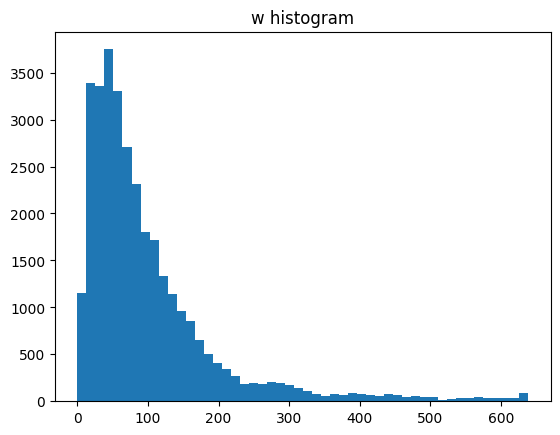

In [14]:
traindataset = CarDataset(train_id, train_df)
valdataset = CarDataset(test_id, train_df)

# Your angle histogram should be as flat as possible to reduce overfitting!
target = train_df["w"]
plt.hist(target, bins=50)
plt.title("w histogram")
plt.show()


In [15]:
classes

array(['fish', 'starfish', 'jellyfish', 'shark', 'stingray', 'penguin',
       'puffin'], dtype=object)

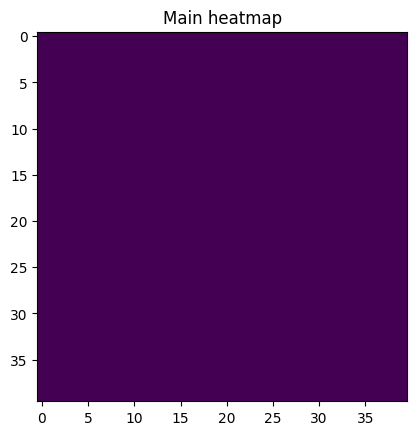

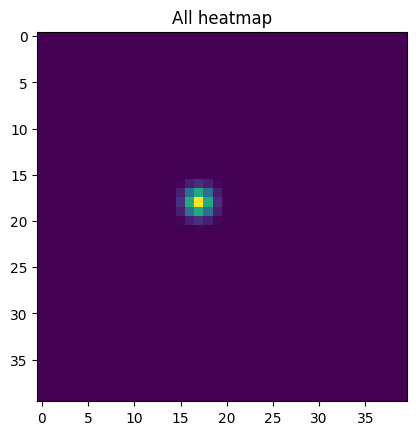

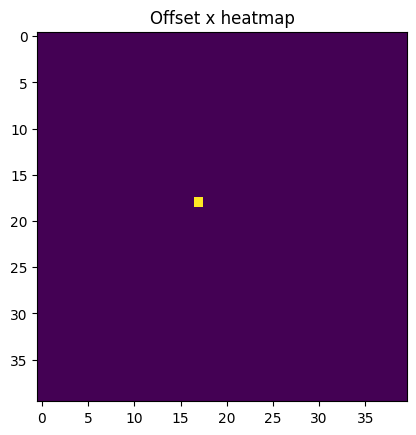

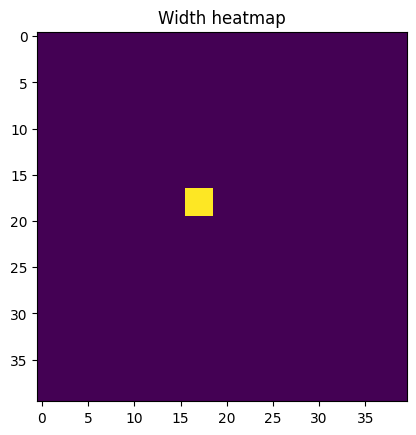

[]
[]


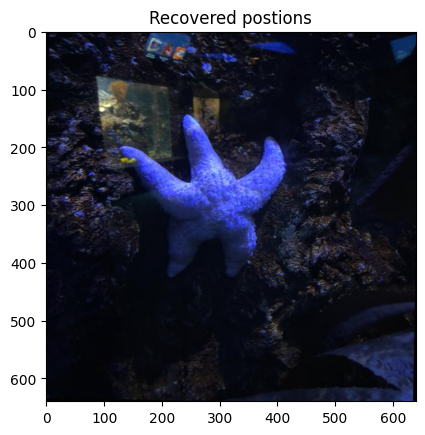

In [16]:
# Check traindataset

k = random.randint(0, len(train_id))
# Test dataset
img, hm, offset, regr,hm_all = traindataset[k]

plt.imshow(hm[0])
plt.title("Main heatmap")
plt.show()

plt.imshow(hm_all)
plt.title("All heatmap")
plt.show()

plt.imshow(offset[0])
plt.title("Offset x heatmap")
plt.show()

plt.imshow(regr[0])
plt.title("Width heatmap")
plt.show()

#print(cos_sin_hm.shape)

# plt.imshow(cos_sin_hm[0])
# plt.title("Cos heatmap")
# plt.show()

# plt.imshow(cos_sin_hm[1])
# plt.title("Sin heatmap")
# plt.show()

# Recover ball detection from heatmaps
img = cv2.imread(os.path.join(dataset_folder+"train", train_id[k]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img,(16,16))
img = showbox(img, hm[0], offset, regr, 0.99)

plt.imshow(img)
plt.title("Recovered postions")
plt.show()

In [17]:
train_loader = torch.utils.data.DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(valdataset,batch_size=batch_size,shuffle=True)

## Define Centernet model

In [18]:
class centernet(nn.Module):
    def __init__(self):
        super(centernet, self).__init__()
        
        # Resnet-18 as backbone.
        basemodel = torchvision.models.resnet18(pretrained=True)
        
        # DO NOT FREEZE ResNet weights
        #for param in basemodel.parameters():
        #    param.requires_grad = False
        
        # Select only first layers up when you reach 80x45 dimensions with 256 channels
        self.base_model = nn.Sequential(*list(basemodel.children())[:-3])
        
        num_ch = 256
        head_conv = 64
        self.outc = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, len(classes), kernel_size=1, stride=1))
        
        self.outo = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outr = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
        self.outa = nn.Sequential(
                nn.Conv2d(num_ch, head_conv, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(head_conv, 2, kernel_size=1, stride=1))
        
    def forward(self, x):
        # [b, 3, 720, 1280]
        
        x = self.base_model(x)
        # [b, 128, 90, 160] 
        
        assert not torch.isnan(x).any()
        
        outc = self.outc(x) 
        # [b, 1, 90, 160]
        assert not torch.isnan(outc).any()
        
        outo = self.outo(x)
        # [b, 2, 90, 160]
        assert not torch.isnan(outo).any()
        
        outr = self.outr(x)
        #outa = self.outa(x)
        
        return outc, outo, outr #, outa

In [19]:
import math
import torch.nn as nn
from torch.hub import load_state_dict_from_url

model_urls = {
    'resnet18': 'https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth',
    'resnet34': 'https://s3.amazonaws.com/pytorch/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://s3.amazonaws.com/pytorch/models/resnet50-19c8e357.pth',
    'resnet101': 'https://s3.amazonaws.com/pytorch/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://s3.amazonaws.com/pytorch/models/resnet152-b121ed2d.pth',
}

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, # change
                    padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

#-----------------------------------------------------------------#
#   使用Renset50作为主干特征提取网络，最终会获得一个
#   16x16x2048的有效特征层
#-----------------------------------------------------------------#
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        # 512,512,3 -> 256,256,64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # 256x256x64 -> 128x128x64
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True) # change

        # 128x128x64 -> 128x128x256
        self.layer1 = self._make_layer(block, 64, layers[0])

        # 128x128x256 -> 64x64x512
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)

        # 64x64x512 -> 32x32x1024
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  

        # 32x32x1024 -> 16x16x2048
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                    kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes * block.expansion),
        )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50(pretrained = True):
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['resnet50'], model_dir = 'model_data/')
        model.load_state_dict(state_dict)
    #----------------------------------------------------------#
    #   获取特征提取部分
    #----------------------------------------------------------#
    features = list([model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3, model.layer4])
    features = nn.Sequential(*features)
    return features

class resnet50_Decoder(nn.Module):
    def __init__(self, inplanes, bn_momentum=0.1):
        super(resnet50_Decoder, self).__init__()
        self.bn_momentum = bn_momentum
        self.inplanes = inplanes
        self.deconv_with_bias = False
        
        #----------------------------------------------------------#
        #   16,16,2048 -> 32,32,256 -> 64,64,128 -> 128,128,64
        #   利用ConvTranspose2d进行上采样。
        #   每次特征层的宽高变为原来的两倍。
        #----------------------------------------------------------#
        self.deconv_layers = self._make_deconv_layer(
            num_layers=3,
            num_filters=[256, 128, 64],
            num_kernels=[4, 4, 4],
        )

    def _make_deconv_layer(self, num_layers, num_filters, num_kernels):
        layers = []
        for i in range(num_layers):
            kernel = num_kernels[i]
            planes = num_filters[i]

            layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=1,
                    output_padding=0,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=self.bn_momentum))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.deconv_layers(x)


class resnet50_Head(nn.Module):
    def __init__(self, num_classes=80, channel=64, bn_momentum=0.1):
        super(resnet50_Head, self).__init__()
        #-----------------------------------------------------------------#
        #   对获取到的特征进行上采样，进行分类预测和回归预测
        #   128, 128, 64 -> 128, 128, 64 -> 128, 128, num_classes
        #                -> 128, 128, 64 -> 128, 128, 2
        #                -> 128, 128, 64 -> 128, 128, 2
        #-----------------------------------------------------------------#
        # 热力图预测部分
        self.cls_head = nn.Sequential(
            nn.Conv2d(64, channel,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, num_classes,
                      kernel_size=1, stride=1, padding=0))
        # 宽高预测的部分
        self.wh_head = nn.Sequential(
            nn.Conv2d(64, channel,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, 2,
                      kernel_size=1, stride=1, padding=0))

        # 中心点预测的部分
        self.reg_head = nn.Sequential(
            nn.Conv2d(64, channel,
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64, momentum=bn_momentum),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, 2,
                      kernel_size=1, stride=1, padding=0))

    def forward(self, x):
        hm = self.cls_head(x) #.sigmoid_()
        wh = self.wh_head(x)
        offset = self.reg_head(x)
        return hm,offset,wh


class CenterNet_Resnet50(nn.Module):
    def __init__(self, num_classes = 20, pretrained = False):
        super(CenterNet_Resnet50, self).__init__()
        self.pretrained = pretrained
        # 512,512,3 -> 16,16,2048
        self.backbone = resnet50(pretrained = pretrained)
        # 16,16,2048 -> 128,128,64
        self.decoder = resnet50_Decoder(2048)
        #-----------------------------------------------------------------#
        #   对获取到的特征进行上采样，进行分类预测和回归预测
        #   128, 128, 64 -> 128, 128, 64 -> 128, 128, num_classes
        #                -> 128, 128, 64 -> 128, 128, 2
        #                -> 128, 128, 64 -> 128, 128, 2
        #-----------------------------------------------------------------#
        self.head = resnet50_Head(channel=64, num_classes=num_classes)
        
        self._init_weights()

    def freeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False

    def unfreeze_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = True

    def _init_weights(self):
        if not self.pretrained:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
        
        self.head.cls_head[-1].weight.data.fill_(0)
        self.head.cls_head[-1].bias.data.fill_(-2.19)
        
    def forward(self, x):
        feat = self.backbone(x)
        return self.head(self.decoder(feat))

In [20]:
model = CenterNet_Resnet50(len(classes), pretrained = True)
# Check if it runs correctly
output = model(torch.rand(1,3,input_height,input_width))
print(output[0].size())
print(output[1].size())


torch.Size([1, 7, 160, 160])
torch.Size([1, 2, 160, 160])


In [21]:
summary(model, torch.rand((1, 3, input_height, input_width)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 20, 20]        --
|    └─Conv2d: 2-1                       [-1, 64, 320, 320]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 320, 320]        128
|    └─ReLU: 2-3                         [-1, 64, 320, 320]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 160, 160]        --
|    └─Sequential: 2-5                   [-1, 256, 160, 160]       --
|    |    └─Bottleneck: 3-1              [-1, 256, 160, 160]       75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 160, 160]       70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 160, 160]       70,400
|    └─Sequential: 2-6                   [-1, 512, 80, 80]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 80, 80]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 80, 80]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 80, 80] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 20, 20]        --
|    └─Conv2d: 2-1                       [-1, 64, 320, 320]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 320, 320]        128
|    └─ReLU: 2-3                         [-1, 64, 320, 320]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 160, 160]        --
|    └─Sequential: 2-5                   [-1, 256, 160, 160]       --
|    |    └─Bottleneck: 3-1              [-1, 256, 160, 160]       75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 160, 160]       70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 160, 160]       70,400
|    └─Sequential: 2-6                   [-1, 512, 80, 80]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 80, 80]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 80, 80]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 80, 80] 

# Define Loss (Focal loss + L1-loss)

In [22]:
def focal_loss(pred_mask, gt,gamma=0.2):
    """
    Focal loss was introduced to address the class imbalance problem
    For example here, most of the pixels in the heatmap are negative.
    
    We split the focal loss between positive and negative losses.
    
    https://arxiv.org/pdf/1708.02002.pdf
    
    Code taken from the CenterNet repo.
    """
    gt = gt.unsqueeze(1).float()

    pos_inds = gt.ge(1.0).float()
    neg_inds = gt.lt(1.0).float()
    
    neg_weights = torch.pow(1 - gt, 4)
    
    # add 1e-12 to avoid nan values
    pos_loss = - torch.pow(1 - pred_mask, gamma) * torch.log(pred_mask + 1e-12) * pos_inds # [2, 1, 128, 128]
    neg_loss = - torch.pow(pred_mask, gamma) * torch.log(1 - pred_mask + 1e-12) * neg_inds * neg_weights # [2, 1, 128, 128]
    
    loss = 0
    
    num_pos  = pos_inds.float().sum() # scalar number of positives
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()
    
    if num_pos == 0:
        loss = neg_loss
    else:
        pos_loss /= num_pos
        neg_loss /= num_pos
        loss = pos_loss + neg_loss
        
    assert not torch.isnan(pos_loss)
    assert not torch.isnan(neg_loss)
        
    return loss, pos_loss, neg_loss


def _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all):
    ''' L1 regression loss
    We compute l1 loss over mask of positive pixels for offset, width/height and sine/cosine angle
    '''
    #hm_gt = torch.sum(hm_gt,axis=1)

    mask = hm_all.unsqueeze(1).float().ge(1.0).float()
    
    num = mask.float().sum() 
    mask = mask.expand_as(off_gt).float()
    
    assert off_pred.size() == mask.size()
    off_pred = off_pred * mask
    off_gt = off_gt * mask
    wh_pred = wh_pred * mask
    wh_gt = wh_gt * mask
    # angle_pred = angle_pred * mask
    # angle_gt = angle_gt * mask
    

    off_loss = nn.functional.l1_loss(off_pred, off_gt, reduction='sum') / (num + 1e-4)
    
    # Scale with 0.1 width and height loss (change it you need)
    wh_loss = 0.1 * nn.functional.l1_loss(wh_pred, wh_gt, reduction='sum') / (num + 1e-4)
    
    #angle_loss = nn.functional.l1_loss(angle_pred, angle_gt, reduction='sum') / (num + 1e-4)
    
    return off_loss, wh_loss #, angle_loss

def global_loss(hm_pred, hm_gt, off_pred, off_gt, wh_pred, wh_gt,hm_all):
    """
    Global loss is the sum of the focal loss and of the offset loss
        
    Focal loss is the sum of pos_loss and neg_loss, we extract them just for the record
    """
    
    pred_mask = torch.sigmoid(hm_pred)
    #print(pred_mask.shape)
    
  
    pred_mask = pred_mask.unsqueeze(1).float()
    #print(pred_mask.shape)
    
    foc_loss, pos_loss, neg_loss = focal_loss(pred_mask, hm_gt)
     
    off_loss, wh_loss = _regr_loss(off_pred, off_gt, wh_pred, wh_gt, hm_all)
    
    assert not torch.isnan(off_loss)
        
    return foc_loss, pos_loss, neg_loss, off_loss, wh_loss

# Training

In [23]:
def train(epoch):
    print(f'epochs {epoch+1}/{epochs}')
    print(f'Learning rate : {optimizer.param_groups[0]["lr"]}')
    train_loss = 0.0
    train_pos_loss = 0.0
    train_neg_loss = 0.0
    train_off_loss = 0.0
    train_wh_loss = 0.0
    #train_angle_loss = 0.0
    t = tqdm(train_loader)
    rd = np.random.rand()
    
    # Training
    model.train()
    
    for idx, (img, hm, offset, regr,hm_all) in enumerate(t):       
        # send to gpu
        img = img.to(device)
        hm_gt = hm.to(device)
        offset_gt = offset.to(device)
        wh_gt = regr.to(device)
        hm_all = hm_all.to(device)
        #angle_gt = angle.to(device)
        # set opt
        optimizer.zero_grad()
        
        # run model
        preds_hm, preds_offset, preds_wh = model(img)
        assert not np.isnan(preds_hm.cpu().detach().numpy()[0, 0, 0, 0])
            
        foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)
        loss = foc_loss + off_loss + wh_loss 
        
        if torch.isnan(loss):
            print("NAN loss")
            continue
            
        # misc
        train_loss += float(loss) # TRICK to avoid GPU memory increasing
        train_pos_loss += float(pos_loss)
        train_neg_loss += float(neg_loss)
        train_off_loss += float(off_loss)
        train_wh_loss += float(wh_loss)
        #train_angle_loss += float(angle_loss)
        
        loss.backward()
        # NB: I tried to use gradient clipping to avoid NaN values but it didnt work as expected
        optimizer.step()
        
        t.set_description(f'(l={train_loss/(idx+1):.2f}) (pos={train_pos_loss/(idx+1):.3f}) (neg={train_neg_loss/(idx+1):.3f}) (off={train_off_loss/(idx+1):.3f}) (wh={train_wh_loss/(idx+1):.3f})')
    
    # Validation
    val_loss = 0.0
    val_pos_loss = 0.0
    val_neg_loss = 0.0
    val_off_loss = 0.0
    val_wh_loss = 0.0
    #val_angle_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, hm, offset, regr,hm_all) in enumerate(tqdm(val_loader)):       
            # send to gpu
            img = img.to(device)
            hm_gt = hm.to(device)
            offset_gt = offset.to(device)
            wh_gt = regr.to(device)
            hm_all = hm_all.to(device)
            #angle_gt = angle.to(device)

            # run model
            preds_hm, preds_offset, preds_wh = model(img)

            foc_loss, pos_loss, neg_loss, off_loss, wh_loss = global_loss(preds_hm, hm_gt, preds_offset, offset_gt, preds_wh, wh_gt,hm_all)
            
            loss = foc_loss + off_loss + wh_loss 
            # misc
            val_loss += float(loss)
            val_pos_loss += float(pos_loss)
            val_neg_loss += float(neg_loss)
            val_off_loss += float(off_loss)
            val_wh_loss += float(wh_loss)
            #val_angle_loss += float(angle_loss)


    print(f'train loss : {train_loss/len(train_loader):.4f}')
    print(f'Pos loss : {train_pos_loss/len(train_loader):.4f}')
    print(f'Neg loss : {train_neg_loss/len(train_loader):.4f}')
    print(f'Off loss : {train_off_loss/len(train_loader):.4f}')
    print(f'Wh loss : {train_wh_loss/len(train_loader):.4f}')
    #print(f'Angle loss : {train_angle_loss/len(train_loader):.4f}')
    
    print("")
    print(f'Val loss : {val_loss/len(val_loader):.4f}')
    print(f'Val Pos loss : {val_pos_loss/len(val_loader):.4f}')
    print(f'Val Neg loss : {val_neg_loss/len(val_loader):.4f}')
    print(f'Val Off loss : {val_off_loss/len(val_loader):.4f}')
    print(f'Val Wh loss : {val_wh_loss/len(val_loader):.4f}')
    #print(f'Val Angle loss : {val_angle_loss/len(val_loader):.4f}')
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                'train_loss': train_loss/len(train_loader), 'train_pos_loss': train_pos_loss/len(train_loader),
                'train_neg_loss': train_neg_loss/len(train_loader), 'train_off_loss': train_off_loss/len(train_loader), 
                'val_loss': val_loss/len(val_loader), 'val_pos_loss': val_pos_loss/len(val_loader),
                'val_neg_loss': val_neg_loss/len(val_loader), 'val_off_loss': val_off_loss/len(val_loader)}
    logs.append(log_epoch)
    
    return val_loss/len(val_loader)

In [24]:
#model = CenterNet_Resnet50(len(classes), pretrained = True)
model = centernet()
#model.load_state_dict(torch.load("centernet-oriented-bbox.pth"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

logs = []
best_loss = float('inf')

/home/rivian/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rivian/anaconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
img, hm, offset, regr,hm_all = next(iter(train_loader))

In [26]:
hm.shape

torch.Size([4, 7, 40, 40])

In [27]:
img.shape

torch.Size([4, 3, 640, 640])

In [28]:
epochs = 15 

for epoch in range(epochs):
    val_loss = train(epoch)
    if val_loss < best_loss:
        best_loss = val_loss
        print(f"Improved validation loss to {best_loss:.3f}")
        torch.save(model.state_dict(), "centernet-box-bbox_.pth")   


epochs 1/15
Learning rate : 0.0001


(l=74.30) (pos=4.669) (neg=68.370) (off=0.509) (wh=0.749): 100%|█| 896/896 [01:1
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.59it/s]


train loss : 74.2969
Pos loss : 4.6689
Neg loss : 68.3700
Off loss : 0.5093
Wh loss : 0.7487

Val loss : 7.9328
Val Pos loss : 5.1031
Val Neg loss : 1.6036
Val Off loss : 0.5013
Val Wh loss : 0.7248
Improved validation loss to 7.933
epochs 2/15
Learning rate : 0.0001


(l=7.14) (pos=4.930) (neg=1.088) (off=0.482) (wh=0.638): 100%|█| 896/896 [01:14<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.92it/s]


train loss : 7.1377
Pos loss : 4.9296
Neg loss : 1.0882
Off loss : 0.4816
Wh loss : 0.6383

Val loss : 6.4901
Val Pos loss : 4.4259
Val Neg loss : 1.0170
Val Off loss : 0.4598
Val Wh loss : 0.5874
Improved validation loss to 6.490
epochs 3/15
Learning rate : 0.0001


(l=5.85) (pos=4.011) (neg=0.906) (off=0.438) (wh=0.499): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.98it/s]


train loss : 5.8529
Pos loss : 4.0105
Neg loss : 0.9057
Off loss : 0.4380
Wh loss : 0.4987

Val loss : 5.1168
Val Pos loss : 3.3429
Val Neg loss : 0.9042
Val Off loss : 0.4278
Val Wh loss : 0.4419
Improved validation loss to 5.117
epochs 4/15
Learning rate : 0.0001


(l=4.68) (pos=3.082) (neg=0.771) (off=0.413) (wh=0.415): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.97it/s]


train loss : 4.6815
Pos loss : 3.0823
Neg loss : 0.7714
Off loss : 0.4126
Wh loss : 0.4152

Val loss : 4.3776
Val Pos loss : 2.9308
Val Neg loss : 0.6621
Val Off loss : 0.4008
Val Wh loss : 0.3840
Improved validation loss to 4.378
epochs 5/15
Learning rate : 0.0001


(l=3.81) (pos=2.400) (neg=0.665) (off=0.389) (wh=0.357): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.91it/s]


train loss : 3.8105
Pos loss : 2.3996
Neg loss : 0.6653
Off loss : 0.3887
Wh loss : 0.3569

Val loss : 3.6157
Val Pos loss : 2.2993
Val Neg loss : 0.6015
Val Off loss : 0.3896
Val Wh loss : 0.3254
Improved validation loss to 3.616
epochs 6/15
Learning rate : 0.0001


(l=3.03) (pos=1.781) (neg=0.562) (off=0.371) (wh=0.319): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.89it/s]


train loss : 3.0329
Pos loss : 1.7811
Neg loss : 0.5624
Off loss : 0.3707
Wh loss : 0.3186

Val loss : 3.1648
Val Pos loss : 2.0389
Val Neg loss : 0.4281
Val Off loss : 0.3743
Val Wh loss : 0.3234
Improved validation loss to 3.165
epochs 7/15
Learning rate : 0.0001


(l=2.38) (pos=1.274) (neg=0.469) (off=0.356) (wh=0.285): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.92it/s]


train loss : 2.3838
Pos loss : 1.2736
Neg loss : 0.4688
Off loss : 0.3562
Wh loss : 0.2852

Val loss : 2.5372
Val Pos loss : 1.3082
Val Neg loss : 0.5873
Val Off loss : 0.3652
Val Wh loss : 0.2765
Improved validation loss to 2.537
epochs 8/15
Learning rate : 0.0001


(l=1.90) (pos=0.909) (neg=0.386) (off=0.339) (wh=0.265): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.98it/s]


train loss : 1.8990
Pos loss : 0.9093
Neg loss : 0.3856
Off loss : 0.3390
Wh loss : 0.2651

Val loss : 2.2155
Val Pos loss : 1.1195
Val Neg loss : 0.4760
Val Off loss : 0.3502
Val Wh loss : 0.2698
Improved validation loss to 2.215
epochs 9/15
Learning rate : 0.0001


(l=1.52) (pos=0.636) (neg=0.318) (off=0.326) (wh=0.243): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.98it/s]


train loss : 1.5229
Pos loss : 0.6359
Neg loss : 0.3181
Off loss : 0.3263
Wh loss : 0.2426

Val loss : 2.0397
Val Pos loss : 1.1166
Val Neg loss : 0.3386
Val Off loss : 0.3461
Val Wh loss : 0.2383
Improved validation loss to 2.040
epochs 10/15
Learning rate : 0.0001


(l=1.26) (pos=0.462) (neg=0.262) (off=0.310) (wh=0.224): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.91it/s]


train loss : 1.2572
Pos loss : 0.4616
Neg loss : 0.2615
Off loss : 0.3105
Wh loss : 0.2236

Val loss : 2.0280
Val Pos loss : 1.1096
Val Neg loss : 0.3332
Val Off loss : 0.3491
Val Wh loss : 0.2362
Improved validation loss to 2.028
epochs 11/15
Learning rate : 0.0001


(l=1.07) (pos=0.348) (neg=0.218) (off=0.298) (wh=0.207): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.95it/s]


train loss : 1.0705
Pos loss : 0.3478
Neg loss : 0.2182
Off loss : 0.2975
Wh loss : 0.2070

Val loss : 1.7951
Val Pos loss : 0.9804
Val Neg loss : 0.2682
Val Off loss : 0.3254
Val Wh loss : 0.2211
Improved validation loss to 1.795
epochs 12/15
Learning rate : 0.0001


(l=0.94) (pos=0.263) (neg=0.188) (off=0.287) (wh=0.197): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.99it/s]


train loss : 0.9351
Pos loss : 0.2633
Neg loss : 0.1885
Off loss : 0.2866
Wh loss : 0.1967

Val loss : 1.9260
Val Pos loss : 1.0890
Val Neg loss : 0.2878
Val Off loss : 0.3305
Val Wh loss : 0.2186
epochs 13/15
Learning rate : 0.0001


(l=0.88) (pos=0.232) (neg=0.176) (off=0.279) (wh=0.189): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.95it/s]


train loss : 0.8753
Pos loss : 0.2316
Neg loss : 0.1757
Off loss : 0.2788
Wh loss : 0.1893

Val loss : 1.7135
Val Pos loss : 0.8510
Val Neg loss : 0.3364
Val Off loss : 0.3242
Val Wh loss : 0.2018
Improved validation loss to 1.713
epochs 14/15
Learning rate : 0.0001


(l=0.75) (pos=0.164) (neg=0.142) (off=0.264) (wh=0.178): 100%|█| 896/896 [01:13<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.96it/s]


train loss : 0.7492
Pos loss : 0.1645
Neg loss : 0.1424
Off loss : 0.2639
Wh loss : 0.1784

Val loss : 2.0026
Val Pos loss : 1.2300
Val Neg loss : 0.2325
Val Off loss : 0.3178
Val Wh loss : 0.2223
epochs 15/15
Learning rate : 0.0001


(l=0.71) (pos=0.149) (neg=0.133) (off=0.255) (wh=0.171): 100%|█| 896/896 [01:14<
100%|█████████████████████████████████████████| 224/224 [00:17<00:00, 12.94it/s]

train loss : 0.7086
Pos loss : 0.1491
Neg loss : 0.1328
Off loss : 0.2555
Wh loss : 0.1713

Val loss : 1.8057
Val Pos loss : 1.1314
Val Neg loss : 0.1681
Val Off loss : 0.3120
Val Wh loss : 0.1943


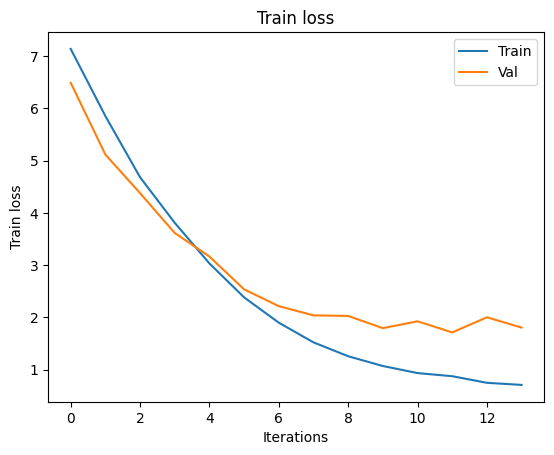

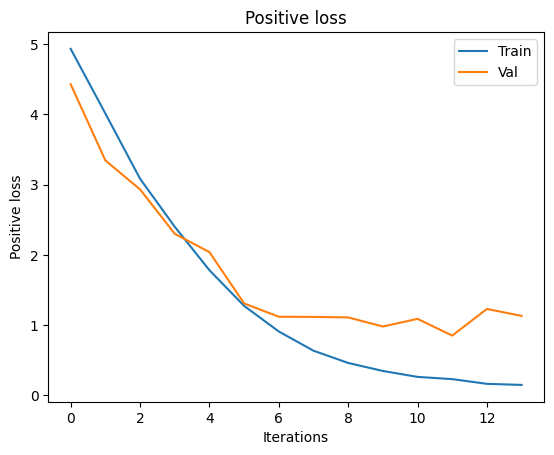

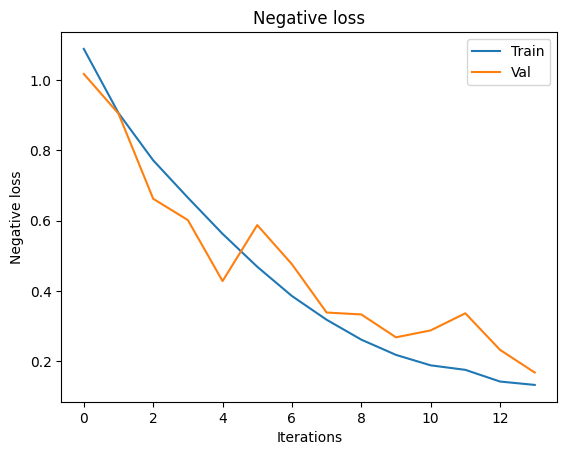

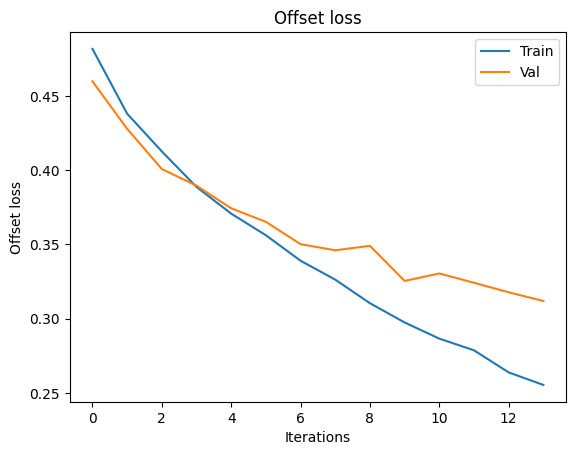

In [29]:
loss_iter = [log["train_loss"] for log in logs]
val_loss_iter = [log["val_loss"] for log in logs]
plt.plot(loss_iter[1:], label="Train")
plt.plot(val_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Train loss")
plt.title("Train loss")
plt.legend()
plt.show()

pos_loss_iter = [log["train_pos_loss"] for log in logs]
val_pos_loss_iter = [log["val_pos_loss"] for log in logs]
plt.plot(pos_loss_iter[1:], label="Train")
plt.plot(val_pos_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Positive loss")
plt.title("Positive loss")
plt.legend()
plt.show()

neg_loss_iter = [log["train_neg_loss"] for log in logs]
val_neg_loss_iter = [log["val_neg_loss"] for log in logs]
plt.plot(neg_loss_iter[1:], label="Train")
plt.plot(val_neg_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Negative loss")
plt.title("Negative loss")
plt.legend()
plt.show()

off_loss_iter = [log["train_off_loss"] for log in logs]
val_off_loss_iter = [log["val_off_loss"] for log in logs]
plt.plot(off_loss_iter[1:], label="Train")
plt.plot(val_off_loss_iter[1:], label="Val")
plt.xlabel("Iterations")
plt.ylabel("Offset loss")
plt.title("Offset loss")
plt.legend()
plt.show()

In [34]:
classes

array(['fish', 'starfish', 'jellyfish', 'shark', 'stingray', 'penguin',
       'puffin'], dtype=object)

# Show predictions

torch.Size([1, 40, 40])


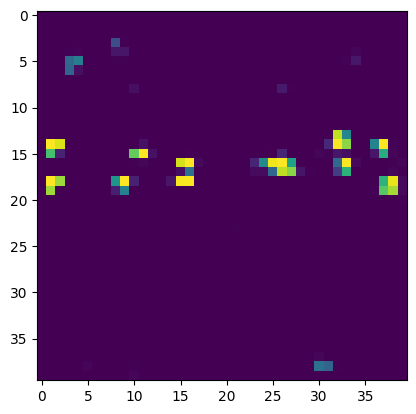

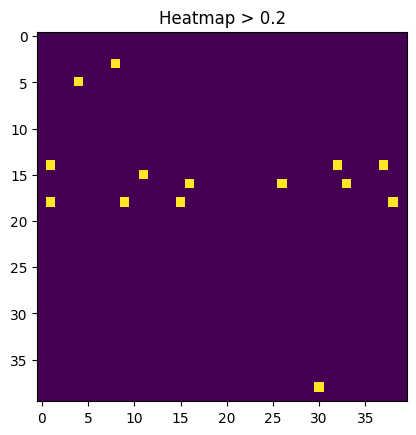

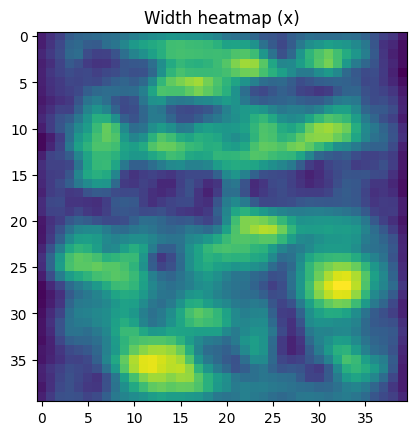

[[4.6282306 1.5545881]
 [4.972938  6.3850846]
 [4.6490912 3.8637118]
 [5.6120415 2.846356 ]
 [5.8453207 2.2936532]
 [4.2675276 1.6931531]
 [5.947397  1.5146505]
 [5.6485796 2.7769802]
 [6.950491  1.6761286]
 [5.093858  2.3213618]
 [7.1025796 2.6475766]
 [5.21902   0.9694136]
 [3.8739424 2.4067566]
 [8.081597  2.5576468]]
[[4.6282306 4.972938  4.6490912 5.6120415 5.8453207 4.2675276 5.947397
  5.6485796 6.950491  5.093858  7.1025796 5.21902   3.8739424 8.081597 ]
 [1.5545881 6.3850846 3.8637118 2.846356  2.2936532 1.6931531 1.5146505
  2.7769802 1.6761286 2.3213618 2.6475766 0.9694136 2.4067566 2.5576468]]
[133, 55]
[66, 87]
[29, 234]
[521, 226]
[595, 237]
[181, 252]
[260, 264]
[422, 265]
[531, 268]
[29, 300]
[150, 299]
[252, 293]
[610, 300]
[489, 611]


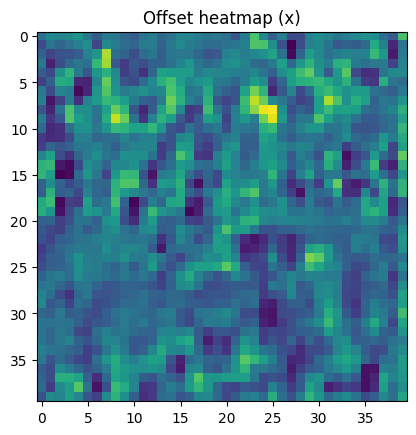

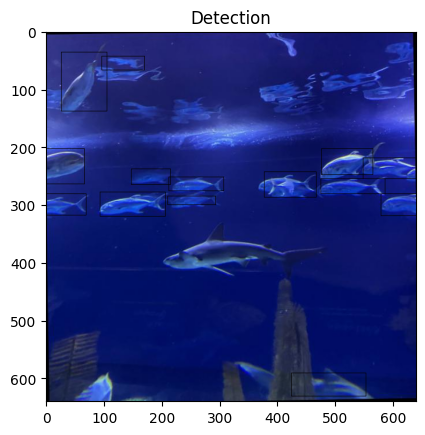

torch.Size([1, 40, 40])


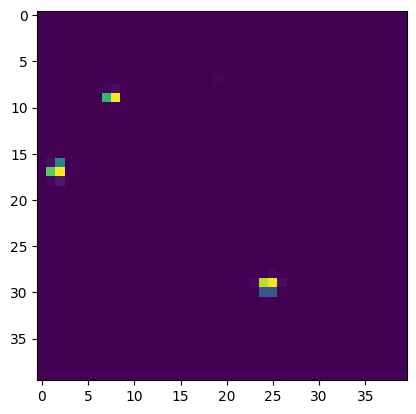

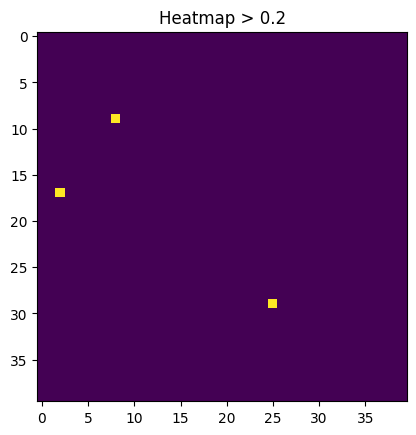

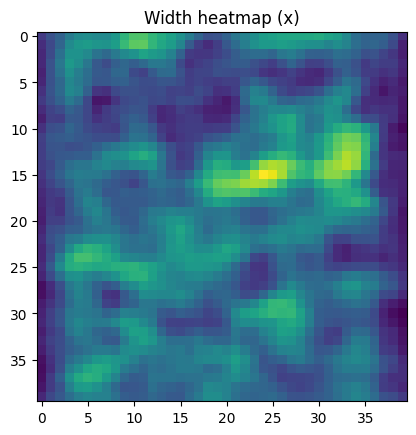

[[ 2.6933079  4.939856 ]
 [ 2.3509197  6.4156857]
 [12.87773    9.165112 ]]
[[ 2.6933079  2.3509197 12.87773  ]
 [ 4.939856   6.4156857  9.165112 ]]
[130, 151]
[35, 284]
[404, 475]


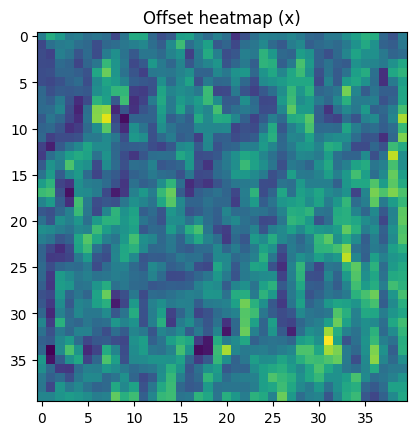

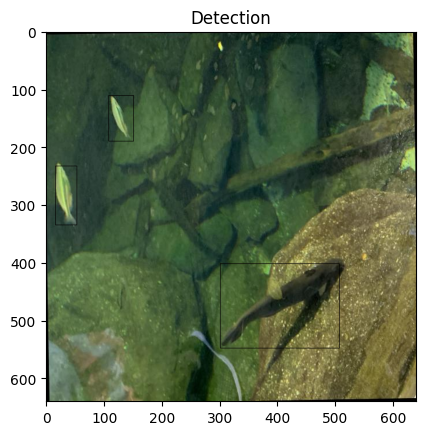

torch.Size([1, 40, 40])


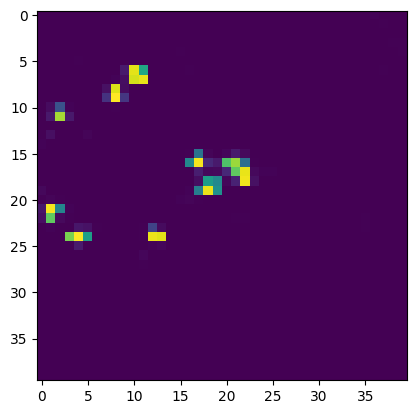

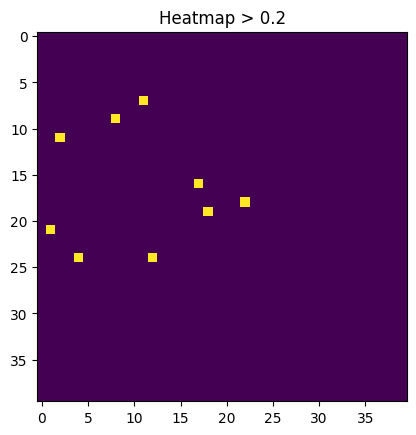

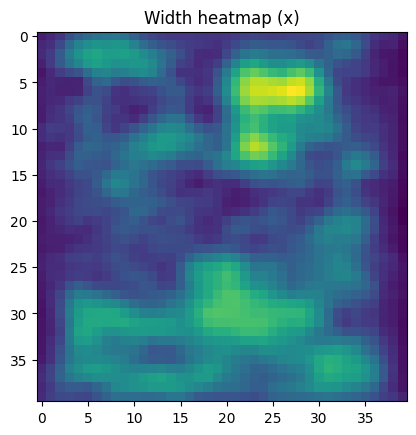

[[4.50833    2.1906056 ]
 [4.2198486  2.0128455 ]
 [4.0883923  1.908035  ]
 [1.682599   0.73925054]
 [2.09234    0.992173  ]
 [4.1555266  1.4901671 ]
 [2.1837242  3.952753  ]
 [5.631569   3.4171972 ]
 [5.523783   2.7004561 ]]
[[4.50833    4.2198486  4.0883923  1.682599   2.09234    4.1555266
  2.1837242  5.631569   5.523783  ]
 [2.1906056  2.0128455  1.908035   0.73925054 0.992173   1.4901671
  3.952753   3.4171972  2.7004561 ]]
[178, 114]
[135, 146]
[37, 177]
[276, 256]
[357, 289]
[293, 307]
[23, 346]
[71, 392]
[202, 388]


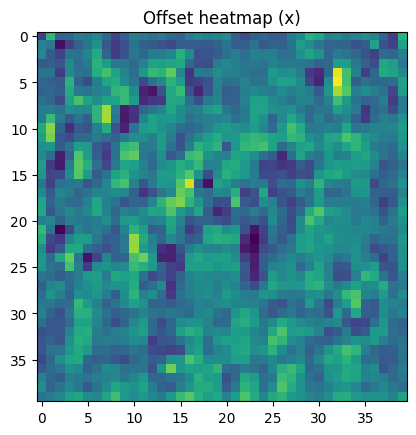

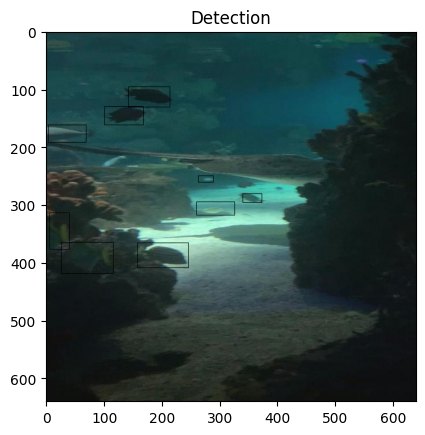

torch.Size([1, 40, 40])


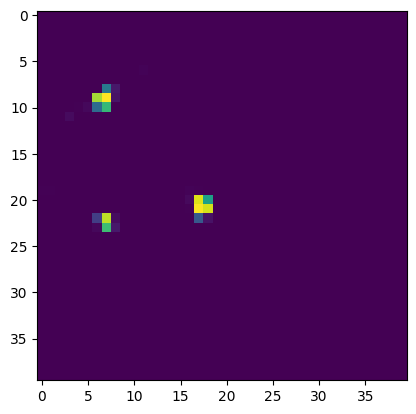

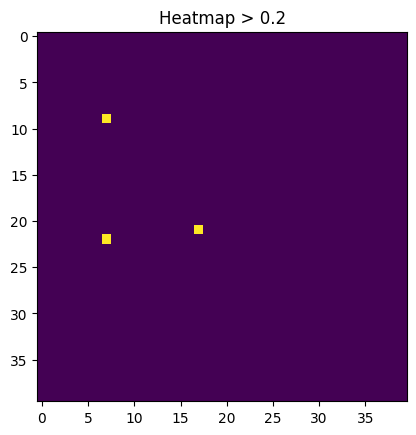

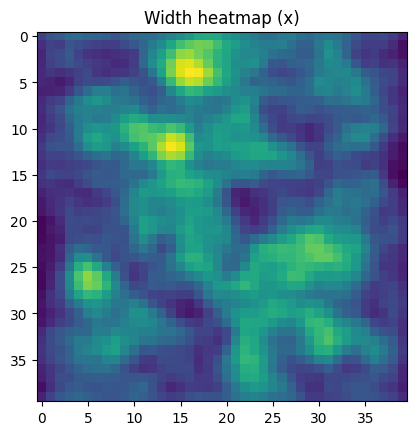

[[ 8.7907    10.702384 ]
 [11.511084  13.306364 ]
 [ 5.2936206  8.042423 ]]
[[ 8.7907    11.511084   5.2936206]
 [10.702384  13.306364   8.042423 ]]
[114, 151]
[281, 339]
[118, 364]


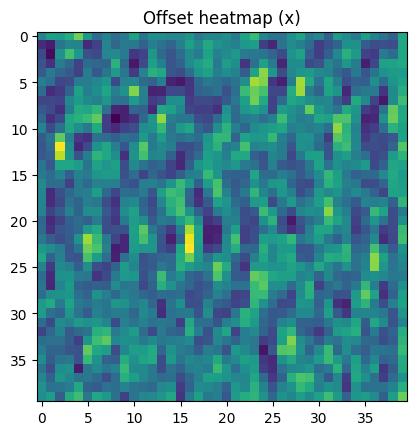

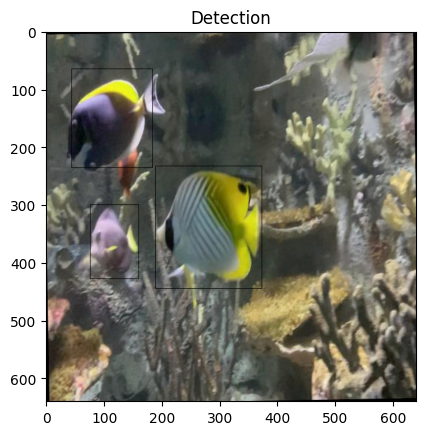

torch.Size([1, 40, 40])


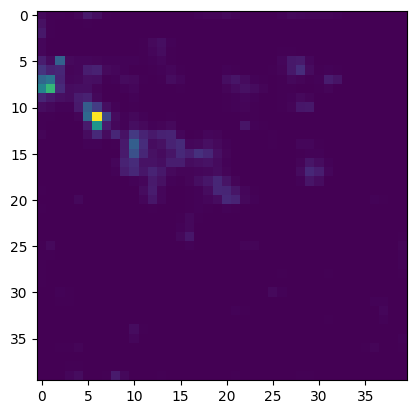

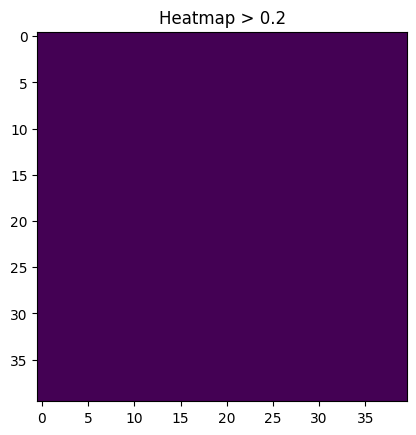

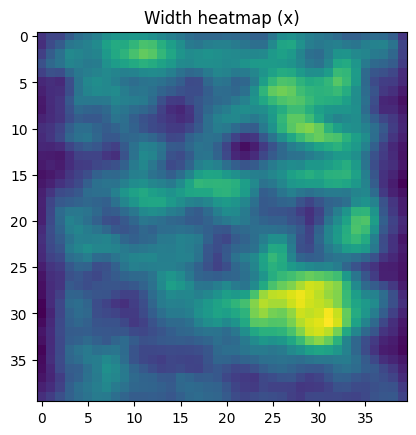

[]
[]


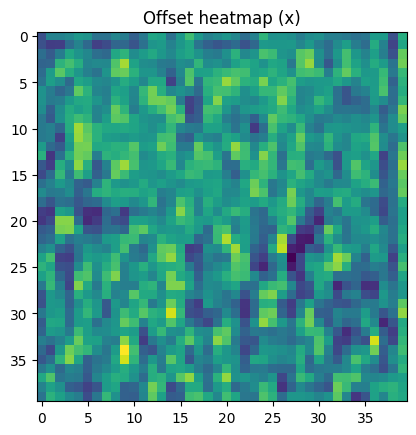

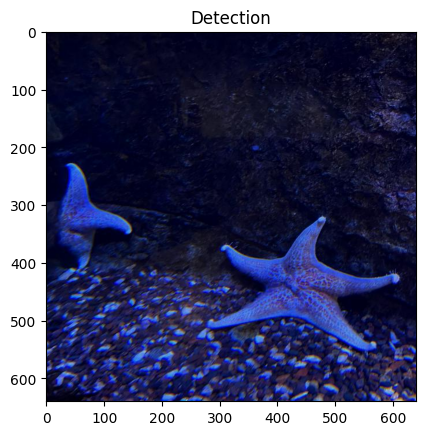

torch.Size([1, 40, 40])


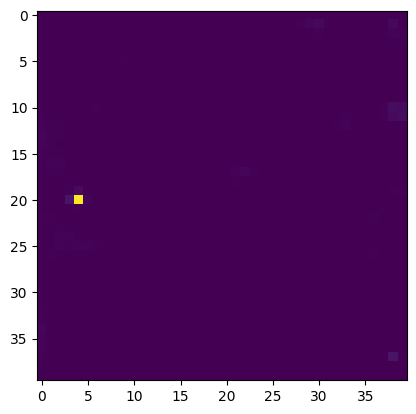

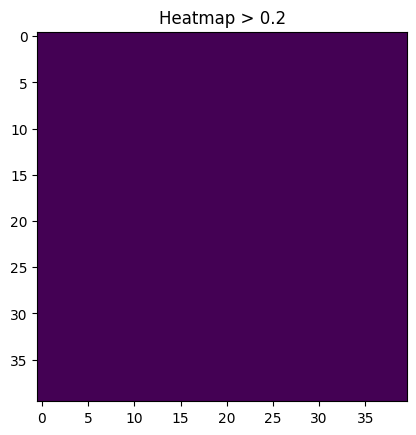

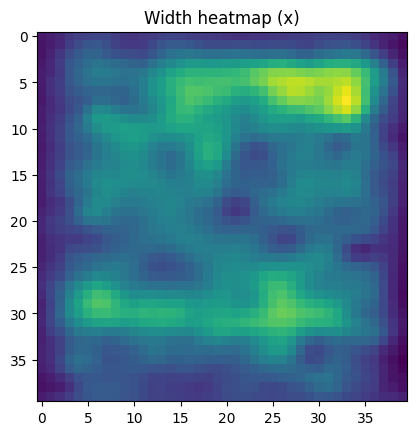

[]
[]


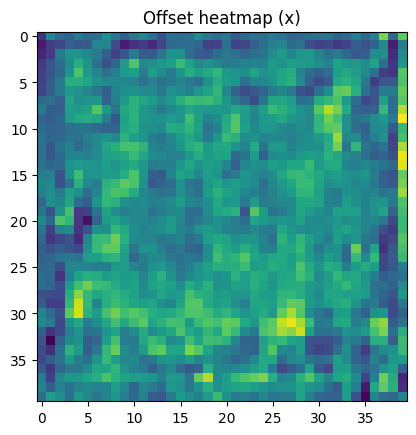

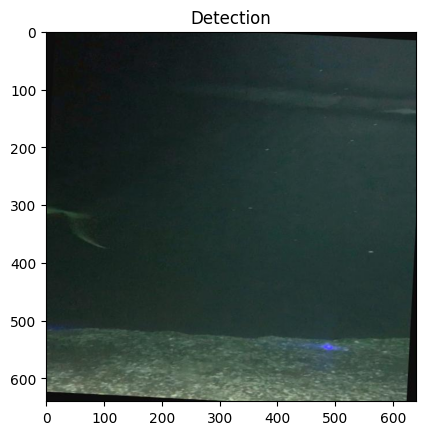

torch.Size([1, 40, 40])


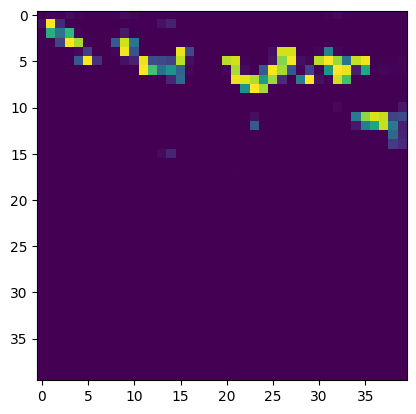

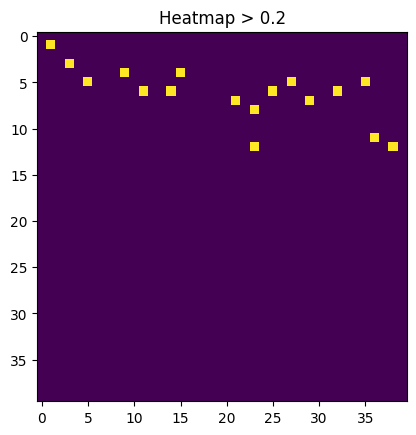

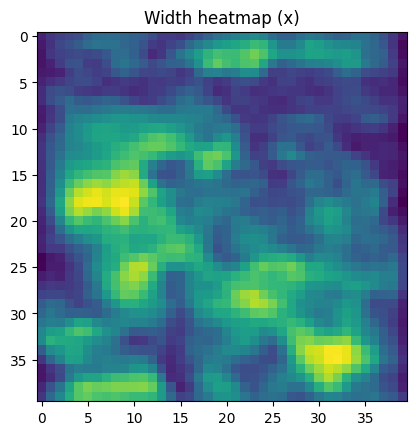

[[2.590508   1.4154707 ]
 [4.789006   1.8539891 ]
 [6.246219   2.8494146 ]
 [2.923945   1.0832901 ]
 [4.597596   1.5835631 ]
 [3.7029858  1.2532395 ]
 [2.5287519  0.797365  ]
 [2.5660682  1.6818554 ]
 [4.210688   0.77760327]
 [2.7946987  0.85848904]
 [3.698245   0.98750323]
 [3.6223018  1.1476983 ]
 [3.9371054  1.1461323 ]
 [3.2627466  0.99182886]
 [1.5948375  1.0172116 ]
 [2.7313755  1.8467958 ]
 [1.736107   1.4281604 ]]
[[2.590508   4.789006   6.246219   2.923945   4.597596   3.7029858
  2.5287519  2.5660682  4.210688   2.7946987  3.698245   3.6223018
  3.9371054  3.2627466  1.5948375  2.7313755  1.736107  ]
 [1.4154707  1.8539891  2.8494146  1.0832901  1.5835631  1.2532395
  0.797365   1.6818554  0.77760327 0.85848904 0.98750323 1.1476983
  1.1461323  0.99182886 1.0172116  1.8467958  1.4281604 ]]
[22, 28]
[55, 48]
[152, 67]
[250, 76]
[86, 87]
[436, 81]
[561, 91]
[186, 95]
[233, 104]
[408, 107]
[523, 110]
[348, 114]
[467, 115]
[375, 130]
[585, 188]
[373, 192]
[615, 198]


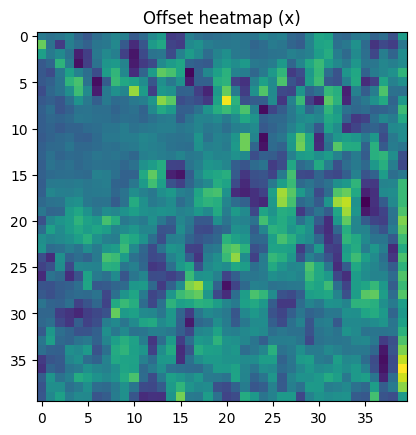

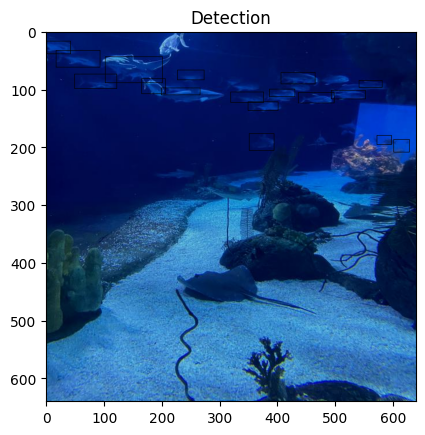

torch.Size([1, 40, 40])


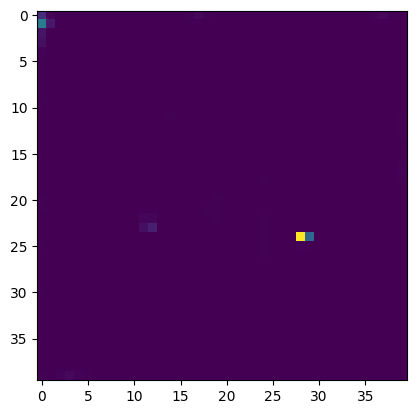

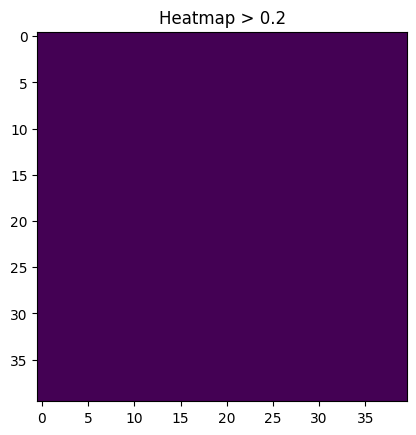

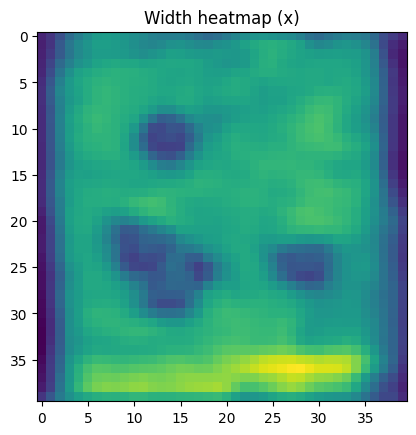

[]
[]


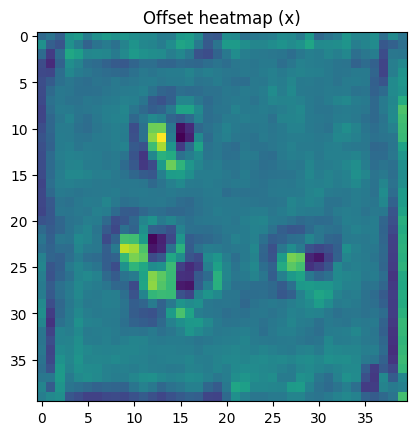

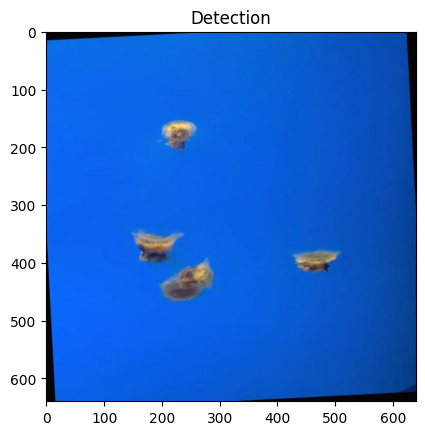

torch.Size([1, 40, 40])


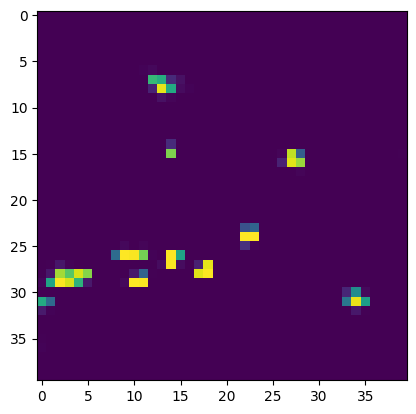

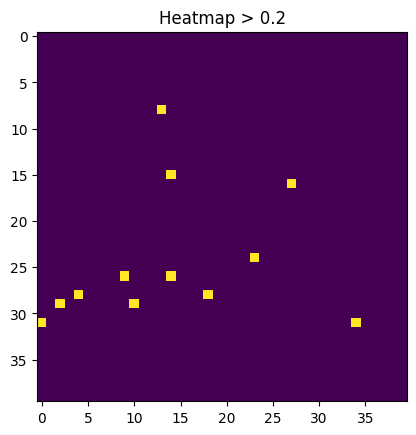

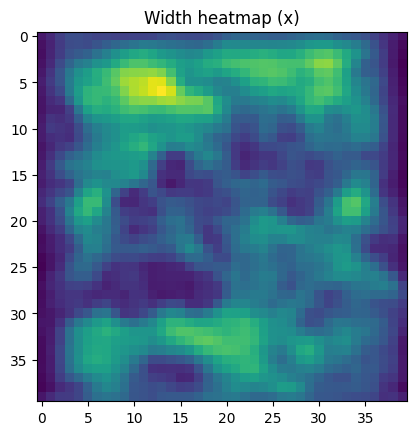

[[20.995113    9.816269  ]
 [ 2.7669992   3.4005303 ]
 [ 6.777736    7.6173563 ]
 [10.930077   10.888352  ]
 [ 4.0872765   2.857969  ]
 [ 1.9990964   1.9834859 ]
 [ 4.092279    1.6887822 ]
 [ 3.4688377   2.4628417 ]
 [ 3.183876    1.7908623 ]
 [ 3.8780177   2.7342162 ]
 [ 0.91473556  2.1021094 ]
 [10.803601    9.265841  ]]
[[20.995113    2.7669992   6.777736   10.930077    4.0872765   1.9990964
   4.092279    3.4688377   3.183876    3.8780177   0.91473556 10.803601  ]
 [ 9.816269    3.4005303   7.6173563  10.888352    2.857969    1.9834859
   1.6887822   2.4628417   1.7908623   2.7342162   2.1021094   9.265841  ]]
[217, 135]
[232, 243]
[441, 260]
[368, 392]
[151, 422]
[235, 427]
[74, 463]
[288, 451]
[40, 468]
[168, 467]
[16, 511]
[551, 502]


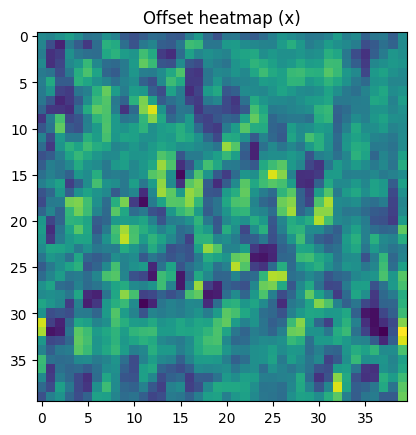

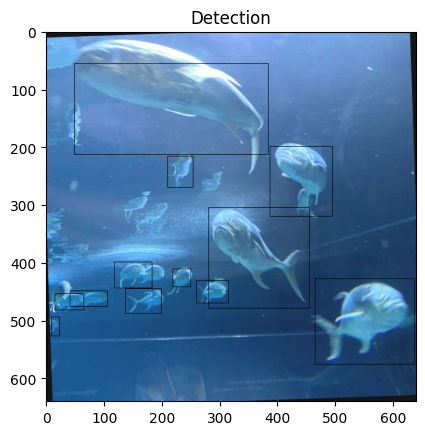

torch.Size([1, 40, 40])


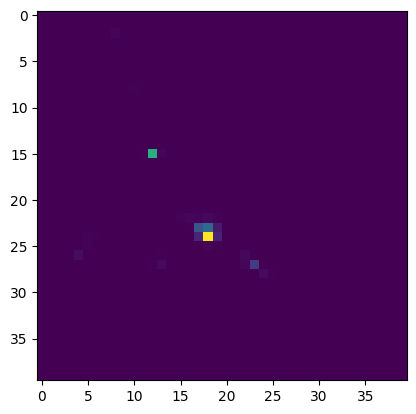

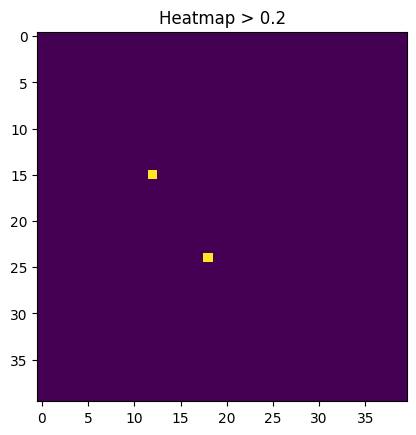

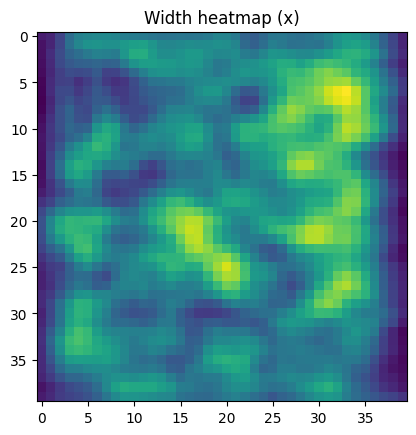

[[ 3.046525   1.0913548]
 [19.807522  13.68506  ]]
[[ 3.046525  19.807522 ]
 [ 1.0913548 13.68506  ]]
[198, 247]
[294, 388]


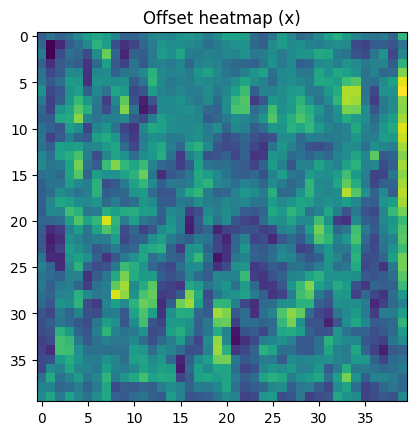

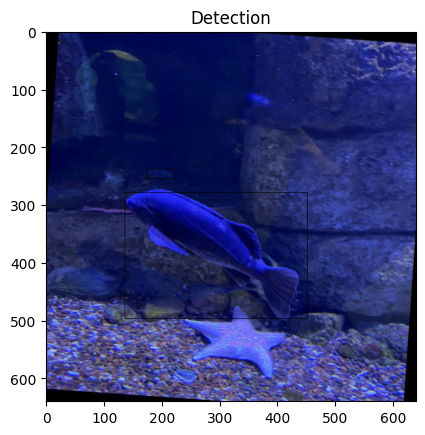

In [37]:
model.load_state_dict(torch.load("centernet-box-bbox_.pth"))
model.eval()

threshold = 0.2

for id in range(10):
    img, hm_gt, offset_gt, regr_gt,hm_all = valdataset[id]
    img = torch.from_numpy(img)
    with torch.no_grad():
        hm, offset, wh = model(img.to(device).float().unsqueeze(0))

    #hm = torch.mean(hm,axis=1)
    
    hm = hm[:,0]
    print(hm.shape)
    hm = hm.cpu().numpy().squeeze(0) #.squeeze(0)
    offset = offset.cpu().numpy().squeeze(0)
    wh = wh.cpu().numpy().squeeze(0)
    #angle = angle.cpu().numpy().squeeze(0)
    
    #print(angle.shape)

    # show image
    img_id = test_id[id]
    img = cv2.imread(os.path.join(dataset_folder+"train", img_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (input_size, input_size))

    # get boxes
    hm = torch.sigmoid(torch.from_numpy(hm)).numpy()
    plt.imshow(hm)
    plt.show()
    hm = select(hm, threshold)
    
    plt.imshow(hm>threshold)
    plt.title(f"Heatmap > {threshold}")
    plt.show()
    
    plt.imshow(wh[0])
    plt.title("Width heatmap (x)")
    plt.show()
    
    sample = showbox(img, hm, offset, wh, threshold)
    plt.imshow(offset[0])
    plt.title("Offset heatmap (x)")
    plt.show()
    
    
    # show gt
    #fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    plt.imshow(sample)
    plt.title("Detection")
    plt.show()